# Convert DMS preferences to a distance map

DMS preferences are reported as a matrix of preference per site and amino acid. To convert these preferences into a distance metric for use in a fitness model, we want to calculate the mutation effect for all pairs of amino acids at all sites.

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys

%matplotlib inline

In [2]:
plt.style.use("huddlej")

## Load data

In [3]:
data = "../data/dms-h3n2-preferences-rescaled.csv"

In [4]:
df = pd.read_csv(data)

In [5]:
df.head()

,site,A,C,D,E,F,G,H,I,K,...,P,Q,R,S,T,V,W,Y,entropy,neffective
0,-16,0.014871,0.085098,0.136767,0.037090,0.025928,0.020988,0.011305,0.082474,0.147416,...,0.000107,0.022513,0.043732,0.010125,0.026076,0.026601,0.039734,0.074225,2.675247,14.515938
1,-15,0.000842,0.005272,0.005332,0.002805,0.038745,0.000387,0.035235,0.172027,0.262394,...,0.000922,0.019696,0.048044,0.003923,0.010624,0.047450,0.083409,0.110740,2.275608,9.733835
2,-14,0.006965,0.068999,0.010278,0.029151,0.028980,0.000074,0.031234,0.020222,0.048197,...,0.060473,0.065088,0.060442,0.039089,0.080455,0.012755,0.092659,0.127560,2.664450,14.360048
3,-13,0.177685,0.180615,0.002740,0.011457,0.023248,0.049499,0.013153,0.062442,0.039223,...,0.013630,0.008927,0.002066,0.028406,0.015607,0.206730,0.005484,0.084061,2.376940,10.771889
4,-12,0.017543,0.014953,0.002865,0.000621,0.080053,0.061449,0.000202,0.165689,0.005086,...,0.000415,0.001055,0.000668,0.009665,0.016923,0.005231,0.485037,0.036957,1.784825,5.958536


## Convert sites to one-based gene-specific coordinates

SigPep coordinates are reported as negative values, HA1 coordinates are reported as is, and HA2 coordinates are all prefixed by "(HA2)".

In [6]:
def annotate_gene_specific_coordinates(site):
    site = int(site.replace("(HA2)", ""))
    if site < 0:
        site = site + 16 + 1

    return site

def annotate_gene(site):
    if site.startswith("(HA2)"):
        return "HA2"
    else:
        site = int(site)
        if site < 0:
            return "SigPep"
        else:
            return "HA1"

In [7]:
df["site"].head()

0    -16
1    -15
2    -14
3    -13
4    -12
Name: site, dtype: object

In [8]:
df["gene"] = df["site"].apply(annotate_gene)

In [9]:
df["position"] = df["site"].apply(annotate_gene_specific_coordinates)

In [10]:
df.head()

,site,A,C,D,E,F,G,H,I,K,...,R,S,T,V,W,Y,entropy,neffective,gene,position
0,-16,0.014871,0.085098,0.136767,0.037090,0.025928,0.020988,0.011305,0.082474,0.147416,...,0.043732,0.010125,0.026076,0.026601,0.039734,0.074225,2.675247,14.515938,SigPep,1
1,-15,0.000842,0.005272,0.005332,0.002805,0.038745,0.000387,0.035235,0.172027,0.262394,...,0.048044,0.003923,0.010624,0.047450,0.083409,0.110740,2.275608,9.733835,SigPep,2
2,-14,0.006965,0.068999,0.010278,0.029151,0.028980,0.000074,0.031234,0.020222,0.048197,...,0.060442,0.039089,0.080455,0.012755,0.092659,0.127560,2.664450,14.360048,SigPep,3
3,-13,0.177685,0.180615,0.002740,0.011457,0.023248,0.049499,0.013153,0.062442,0.039223,...,0.002066,0.028406,0.015607,0.206730,0.005484,0.084061,2.376940,10.771889,SigPep,4
4,-12,0.017543,0.014953,0.002865,0.000621,0.080053,0.061449,0.000202,0.165689,0.005086,...,0.000668,0.009665,0.016923,0.005231,0.485037,0.036957,1.784825,5.958536,SigPep,5


In [149]:
distance_map = {
    "name": "dms_mutation_effect",
    "default": 0.0,
    "map": {}
}
weights = []
values = 0

for index, row in df.iterrows():
    gene = row["gene"]
    position = str(row["position"])
    
    if gene not in distance_map["map"]:
        distance_map["map"][gene] = {}
        
    if position not in distance_map["map"][gene]:
        distance_map["map"][gene][position] = []
    
    for residue_a, preference_a in row["A":"Y"].items():
        for residue_b, preference_b in row["A":"Y"].items():
            if residue_a == residue_b:
                continue

            weight = np.round(np.log2(preference_b / preference_a), 2)
            distance_map["map"][gene][position].append({
                "from": residue_a,
                "to": residue_b,
                "weight": weight
            })
            values += 1

            if index < 6:
                weights.append({"position": "%s:%s" % (gene, position), "weight": weight})

In [141]:
with open("dms_mutation_effect.json", "w") as oh:
    json.dump(distance_map, oh)

In [142]:
!ls -lh dms_mutation_effect.json

-rw-r--r--  1 jlhudd  staff   8.7M Mar  5 15:11 dms_mutation_effect.json


In [143]:
!gzip -c dms_mutation_effect.json > dms_mutation_effect.json.gz

In [144]:
!ls -lh dms*

-rw-r--r--  1 jlhudd  staff   8.7M Mar  5 15:11 dms_mutation_effect.json
-rw-r--r--  1 jlhudd  staff   982K Mar  5 15:12 dms_mutation_effect.json.gz


In [150]:
weights = pd.DataFrame(weights)

In [151]:
weights.shape

(2280, 2)

In [152]:
distance_map["map"]["SigPep"]["1"][:20]

[{'from': 'A', 'to': 'C', 'weight': 2.52},
 {'from': 'A', 'to': 'D', 'weight': 3.2},
 {'from': 'A', 'to': 'E', 'weight': 1.32},
 {'from': 'A', 'to': 'F', 'weight': 0.8},
 {'from': 'A', 'to': 'G', 'weight': 0.5},
 {'from': 'A', 'to': 'H', 'weight': -0.4},
 {'from': 'A', 'to': 'I', 'weight': 2.47},
 {'from': 'A', 'to': 'K', 'weight': 3.31},
 {'from': 'A', 'to': 'L', 'weight': 0.79},
 {'from': 'A', 'to': 'M', 'weight': 2.59},
 {'from': 'A', 'to': 'N', 'weight': 2.42},
 {'from': 'A', 'to': 'P', 'weight': -7.11},
 {'from': 'A', 'to': 'Q', 'weight': 0.6},
 {'from': 'A', 'to': 'R', 'weight': 1.56},
 {'from': 'A', 'to': 'S', 'weight': -0.55},
 {'from': 'A', 'to': 'T', 'weight': 0.81},
 {'from': 'A', 'to': 'V', 'weight': 0.84},
 {'from': 'A', 'to': 'W', 'weight': 1.42},
 {'from': 'A', 'to': 'Y', 'weight': 2.32},
 {'from': 'C', 'to': 'A', 'weight': -2.52}]

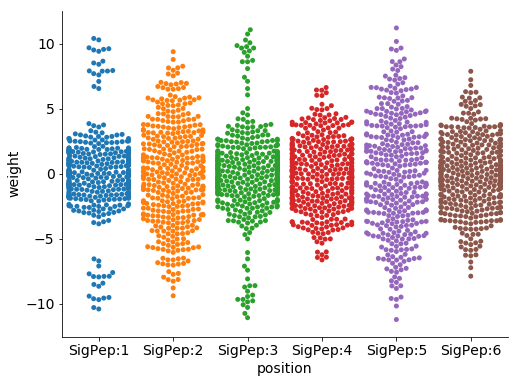

In [154]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
#sns.boxenplot(x="position", y="weight", data=weights, ax=ax)
#sns.violinplot(x="position", y="weight", data=weights, height=8, aspect=0.7)
sns.swarmplot(x="position", y="weight", data=weights)

In [137]:
(np.abs(weights["weight"]) > 1).sum()

2698

In [136]:
weights.shape

(3800, 2)

In [156]:
weights.groupby("position").std()

,weight
position,
SigPep:1,3.136466
SigPep:2,3.869881
SigPep:3,3.423054
SigPep:4,2.686694
SigPep:5,4.319010
SigPep:6,2.824577


In [158]:
df["entropy"].head(6)

0    2.675247
1    2.275608
2    2.664450
3    2.376940
4    1.784825
5    1.900297
Name: entropy, dtype: float64

In [13]:
df.head()

,site,A,C,D,E,F,G,H,I,K,...,R,S,T,V,W,Y,entropy,neffective,gene,position
0,-16,0.014871,0.085098,0.136767,0.037090,0.025928,0.020988,0.011305,0.082474,0.147416,...,0.043732,0.010125,0.026076,0.026601,0.039734,0.074225,2.675247,14.515938,SigPep,1
1,-15,0.000842,0.005272,0.005332,0.002805,0.038745,0.000387,0.035235,0.172027,0.262394,...,0.048044,0.003923,0.010624,0.047450,0.083409,0.110740,2.275608,9.733835,SigPep,2
2,-14,0.006965,0.068999,0.010278,0.029151,0.028980,0.000074,0.031234,0.020222,0.048197,...,0.060442,0.039089,0.080455,0.012755,0.092659,0.127560,2.664450,14.360048,SigPep,3
3,-13,0.177685,0.180615,0.002740,0.011457,0.023248,0.049499,0.013153,0.062442,0.039223,...,0.002066,0.028406,0.015607,0.206730,0.005484,0.084061,2.376940,10.771889,SigPep,4
4,-12,0.017543,0.014953,0.002865,0.000621,0.080053,0.061449,0.000202,0.165689,0.005086,...,0.000668,0.009665,0.016923,0.005231,0.485037,0.036957,1.784825,5.958536,SigPep,5


In [15]:
df.loc[:, "A":"Y"].stack()

0    A    0.014871
     C    0.085098
     D    0.136767
     E    0.037090
     F    0.025928
     G    0.020988
     H    0.011305
     I    0.082474
     K    0.147416
     L    0.025635
     M    0.089640
     N    0.079675
     P    0.000107
     Q    0.022513
     R    0.043732
     S    0.010125
     T    0.026076
     V    0.026601
     W    0.039734
     Y    0.074225
1    A    0.000842
     C    0.005272
     D    0.005332
     E    0.002805
     F    0.038745
     G    0.000387
     H    0.035235
     I    0.172027
     K    0.262394
     L    0.050424
            ...   
564  M    0.008177
     N    0.000708
     P    0.000948
     Q    0.002679
     R    0.150871
     S    0.000833
     T    0.004154
     V    0.043625
     W    0.066214
     Y    0.002703
565  A    0.125628
     C    0.001522
     D    0.009680
     E    0.007064
     F    0.022719
     G    0.001039
     H    0.000969
     I    0.566600
     K    0.000649
     L    0.042566
     M    0.015508
     N    0.

In [24]:
amino_acids = np.array([column for column in df.columns if column not in ("site", "entropy", "neffective", "gene", "position")])

In [25]:
amino_acids

array(['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P',
       'Q', 'R', 'S', 'T', 'V', 'W', 'Y'], dtype='<U1')

In [33]:
long_df = pd.melt(df, id_vars=["gene", "position"], value_vars=amino_acids, var_name="amino_acid", value_name="preference")

In [34]:
long_df.head()

,gene,position,amino_acid,preference
0,SigPep,1,A,0.014871
1,SigPep,2,A,0.000842
2,SigPep,3,A,0.006965
3,SigPep,4,A,0.177685
4,SigPep,5,A,0.017543


In [39]:
long_df.to_json("h3n2_dms_preferences_long.json", orient="records", double_precision=4)